# Fitting

In [1]:
import os
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    Opti, vertcat, horzcat, sum2,
    gradient, jacobian, hessian
)

In [2]:
data_dir = 'data'

## Predator-Prey System Model

$$x_{k+1} = (a x_k - \alpha x_k y_k) / (1 + \gamma x_k)$$ 
$$y_{k+1} = (b y_k - \beta x_k y_k) / (1 + \delta y_k)$$ 

Unknown parameters:

$$
p = \left[
\begin{matrix}
    a & b & \alpha & \beta & \gamma & \delta
\end{matrix} 
\right]^T$$


## 1. Alternative Formulations

### 1.1. Simulate the estimated population dynamics without CasADi

In [3]:
def state_transition(z, a, b, alpha, beta, gamma, delta):
    xk, yk = z[0], z[1]
    xkp1 = (a * xk - alpha * xk * yk) / (1 + gamma * xk)
    ykp1 = (b * yk + beta * xk * yk) / (1 + delta * yk)
    return xkp1, ykp1

p = [1.43, 0.99, 0.22, 0.022, 0.022, 0.011]
xk, yk = [10, 0.1]
print(f"{0:3d}: ({xk:.4f}, {yk:.4f})")
N = 10
z_predicted = [(xk, yk)]
for k in range(1, N+1):
    xk, yk = state_transition((xk, yk), *p)
    z_predicted.append((xk, yk))
    print(f"{k:3d}: ({xk:.4f}, {yk:.4f})")
z_predicted = np.array(z_predicted)

  0: (10.0000, 0.1000)
  1: (11.5410, 0.1209)
  2: (12.9171, 0.1501)
  3: (14.0516, 0.1910)
  4: (14.8979, 0.2476)
  5: (15.4339, 0.3254)
  6: (15.6513, 0.4311)
  7: (15.5445, 0.5725)
  8: (15.1051, 0.7578)
  9: (14.3225, 0.9938)
 10: (13.1929, 1.2829)


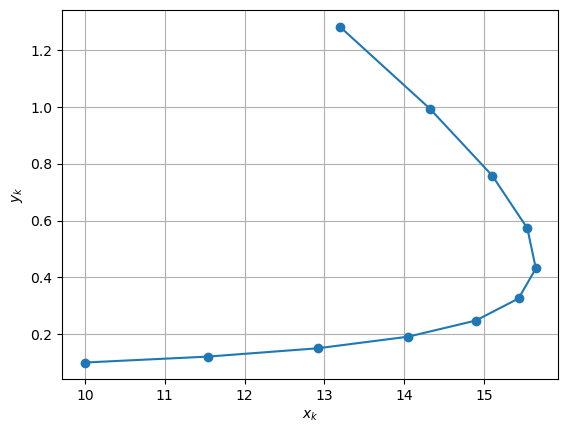

In [4]:
plt.plot(z_predicted[:, 0], z_predicted[:, 1], marker='o')
plt.xlabel('$x_k$')
plt.ylabel('$y_k$')
plt.grid()

In [5]:
assert_array_almost_equal(np.array([xk, yk]), [13.1929, 1.2829], decimal=4)

### 1.2. Compute sum-of-squared-deviations

In [6]:
filename = 'data.mat'
z_data = np.loadtxt(os.path.join(data_dir, filename))
z_data.shape

(101, 2)

In [7]:
errors = z_data[1:11, :] - z_predicted[1:11, :]
errors

array([[-0.87431694, -0.01097694],
       [-1.6817023 , -0.02793707],
       [-2.34973866, -0.05371554],
       [-2.83088477, -0.09214206],
       [-3.09893528, -0.14823668],
       [-3.13951539, -0.22829839],
       [-2.94064131, -0.33971614],
       [-2.48754172, -0.49022574],
       [-1.76403134, -0.68624828],
       [-0.7615959 , -0.93001532]])

In [8]:
sse = np.sum((errors) ** 2)
sse

56.892724199822695

In [9]:
assert round(sse, 3) == 56.893

### 1.3. Fit parameters

In [11]:
opti = Opti()

N = 100
a = opti.variable()
b = opti.variable()
alpha = opti.variable() 
beta = opti.variable()
gamma = opti.variable()
delta = opti.variable()

xk, yk = 10, 0.1

# Construct objective function and add constraints
f = 0
for k in range(1, N + 1):
    xkp1, ykp1 = state_transition(vertcat(xk, yk), a, b, alpha, beta, gamma, delta)
    f += sum2((xkp1 - z_data[k, 0]) ** 2 + (ykp1 - z_data[k, 1]) ** 2)
    xk, yk = xkp1, ykp1

f.shape

(1, 1)

In [12]:
p = vertcat(a, b, alpha, beta, gamma, delta)
opti.minimize(f)
opti.solver('ipopt')
opti.set_initial(p, [1.43, 0.99, 0.22, 0.022, 0.022, 0.011])

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [19]:
sol.value(p)

array([1.3 , 0.9 , 0.2 , 0.02, 0.02, 0.01])

In [20]:
assert_array_almost_equal(sol.value(p), [1.3 , 0.9 , 0.2 , 0.02, 0.02, 0.01])